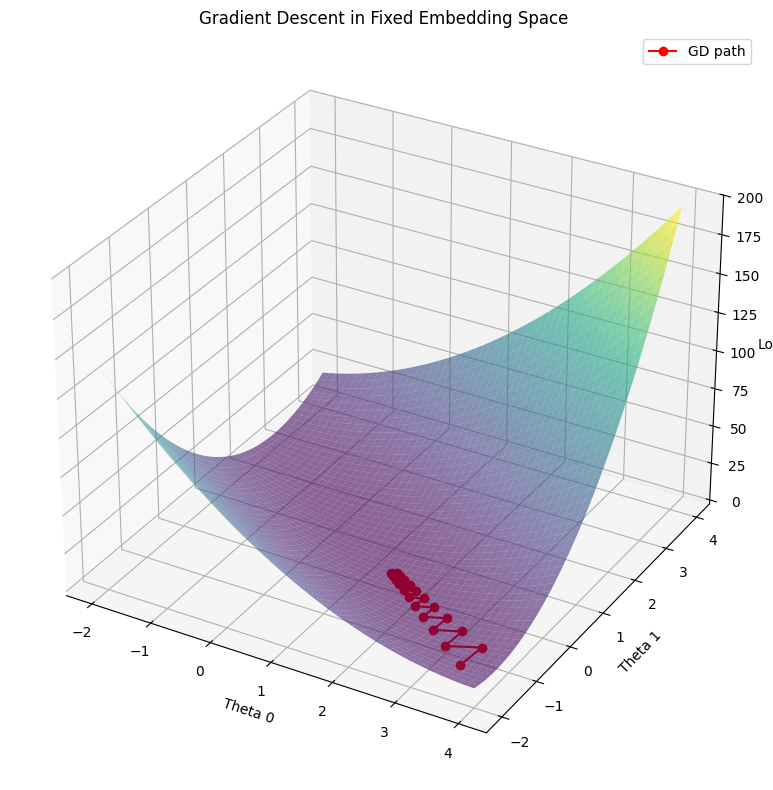

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

# Define a fixed embedding matrix E (as a basis)
E = np.array([[1.0, 0.5],
              [0.5, 1.5]])

# Simulate some input data (e.g., 2D one-hot vectors transformed by E)
inputs = np.array([
    [1, 0],
    [0, 1],
    [1, 1]
])
embedded_inputs = inputs @ E  # Shape: (3, 2)

# Define a simple loss function: squared error to some target point in 2D
target = np.array([2.0, 2.0])

def loss(theta):
    """Loss is sum of squared distances between predicted and target"""
    predictions = embedded_inputs @ theta.reshape(2, 1)
    return np.sum((predictions.squeeze() - target[0])**2)

# Create a grid over parameter space for theta (2D weights)
theta_0_vals = np.linspace(-2, 4, 50)
theta_1_vals = np.linspace(-2, 4, 50)
Theta_0, Theta_1 = np.meshgrid(theta_0_vals, theta_1_vals)

# Compute the loss surface
Loss_surface = np.zeros_like(Theta_0)
for i in range(Theta_0.shape[0]):
    for j in range(Theta_0.shape[1]):
        theta_val = np.array([Theta_0[i, j], Theta_1[i, j]])
        Loss_surface[i, j] = loss(theta_val)

# Simulate gradient descent path
theta_path = [np.array([3.5, -1.5])]
learning_rate = 0.1

for _ in range(20):
    theta = theta_path[-1]
    # Compute gradient numerically
    grad = np.zeros(2)
    eps = 1e-5
    for k in range(2):
        theta_eps = theta.copy()
        theta_eps[k] += eps
        grad[k] = (loss(theta_eps) - loss(theta)) / eps
    theta_next = theta - learning_rate * grad
    theta_path.append(theta_next)

theta_path = np.array(theta_path)

# Plotting the loss surface and the path
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Theta_0, Theta_1, Loss_surface, cmap=cm.viridis, alpha=0.6)
ax.plot(theta_path[:, 0], theta_path[:, 1], [loss(t) for t in theta_path], color='r', marker='o', label='GD path')
ax.set_xlabel('Theta 0')
ax.set_ylabel('Theta 1')
ax.set_zlabel('Loss')
ax.set_title('Gradient Descent in Fixed Embedding Space')
ax.legend()
plt.tight_layout()
plt.show()


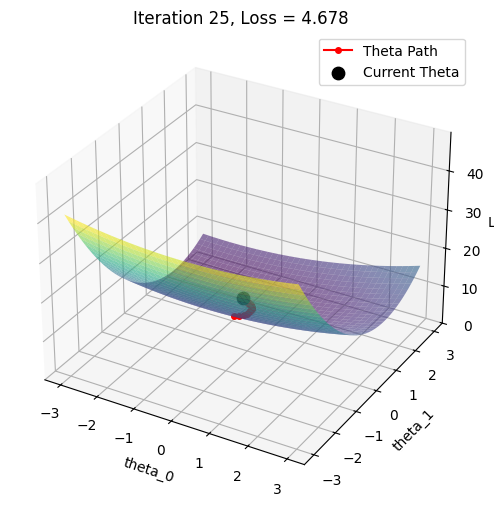

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 1. Define a tiny "dataset"
# -----------------------------
np.random.seed(42)

# Let's say we have 3 "tokens" in one-hot form:
# x1 = [1, 0], x2 = [0, 1], x3 = [1, 1] (toy example)
X = np.array([
    [-1, 0],
    [0, -0.5],
    [1, 1]
])

# Suppose we have some arbitrary target scalar values for these tokens
y = np.array([3.0, 1.0, 4.0])  # just a random set of targets

# -----------------------------
# 2. Initialize E and theta
# -----------------------------
# E: trainable embedding matrix, shape (2, 2)
#    We'll interpret each row as an embedding dimension
E = np.random.randn(2, 2)  # (embedding_dim=2, input_dim=2)

# theta: trainable "downstream" parameters (2D -> scalar)
theta = np.random.randn(2)  # shape (2,)

# -----------------------------
# 3. Define forward pass & loss
# -----------------------------
def forward(X, E, theta):
    """
    X: shape (n_samples, 2) one-hot
    E: shape (2, 2) trainable embedding
    theta: shape (2,) linear map from embedded 2D -> scalar
    """
    # embedded shape: (n_samples, 2)
    embedded = X @ E.T  # or E^T if you prefer
    # predictions shape: (n_samples,)
    preds = embedded @ theta
    return preds

def mse_loss(X, E, theta, y):
    preds = forward(X, E, theta)
    return np.mean((preds - y)**2)

# -----------------------------
# 4. Compute gradients (w.r.t E and theta)
# -----------------------------
def compute_gradients(X, E, theta, y):
    """
    Returns dL/dE and dL/dtheta
    """
    n = X.shape[0]
    # forward pass
    embedded = X @ E.T  # shape (n, 2)
    preds = embedded @ theta  # shape (n,)
    errors = preds - y        # shape (n,)

    # gradient w.r.t theta
    # dL/dtheta = (1/n) * sum( embedded_i * error_i )
    grad_theta = (1/n) * embedded.T @ errors  # shape (2,)

    # gradient w.r.t E
    grad_E = np.zeros_like(E)
    for i in range(n):
        x_i = X[i]            # shape (2,)
        err_i = errors[i]
        grad_E += np.outer(theta, x_i) * err_i
    grad_E /= n
    return grad_E, grad_theta

# -----------------------------
# 5. Gradient descent setup
# -----------------------------
learning_rate = 0.1
n_steps = 25

# We'll store the E, theta, and loss history over time
E_history = [E.copy()]
theta_history = [theta.copy()]
loss_history = [mse_loss(X, E, theta, y)]

for step in range(n_steps):
    dE, dtheta = compute_gradients(X, E, theta, y)
    E = E - learning_rate * dE
    theta = theta - learning_rate * dtheta

    E_history.append(E.copy())
    theta_history.append(theta.copy())
    loss_history.append(mse_loss(X, E, theta, y))

# -----------------------------
# 6. Create animation frames
# -----------------------------
# We'll visualize the loss surface in (theta_0, theta_1) space
# for each iteration i, using the *current* E_history[i].

theta0_vals = np.linspace(-3, 3, 40)
theta1_vals = np.linspace(-3, 3, 40)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

def compute_loss_surface(E_current):
    """
    For the current E, compute MSE loss for a grid of (theta_0, theta_1).
    """
    L = np.zeros_like(T0)
    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            th = np.array([T0[i, j], T1[i, j]])
            L[i, j] = mse_loss(X, E_current, th, y)
    return L

# Precompute surfaces for all iterations to speed up animation
all_surfaces = []
for i in range(n_steps+1):
    E_i = E_history[i]
    surf = compute_loss_surface(E_i)
    all_surfaces.append(surf)

# -----------------------------
# 7. Build the animation
# -----------------------------
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

def init():
    # Initial frame: set labels and title
    ax.clear()
    ax.set_xlabel('theta_0')
    ax.set_ylabel('theta_1')
    ax.set_zlabel('Loss')
    ax.set_title('Dynamic Embedding + Theta Optimization')
    return []

def animate(i):
    ax.clear()

    # Plot the surface for iteration i
    surf = all_surfaces[i]
    ax.plot_surface(T0, T1, surf, alpha=0.6, cmap='viridis')

    # Plot the full path history of theta up to iteration i
    path = np.array(theta_history[:i+1])
    # Use the stored loss history so that each point is plotted at its corresponding loss value
    path_loss = np.array(loss_history[:i+1])
    ax.plot(path[:, 0], path[:, 1], path_loss, color='r', marker='o', markersize=4, label='Theta Path')

    # Highlight the current point
    current_theta = theta_history[i]
    current_loss = loss_history[i]
    ax.scatter(current_theta[0], current_theta[1], current_loss, color='k', s=80, label='Current Theta')

    ax.set_xlabel('theta_0')
    ax.set_ylabel('theta_1')
    ax.set_zlabel('Loss')
    ax.set_title(f'Iteration {i}, Loss = {current_loss:.3f}')
    ax.set_zlim(0, np.max(all_surfaces[0]) * 1.1)  # keep scale consistent
    ax.legend()
    return []

ani = animation.FuncAnimation(fig, animate, frames=n_steps+1, 
                              init_func=init, interval=600, blit=False)

# Uncomment below to save the animation as a GIF (requires imagemagick or pillow)

ani.save("dynamic_embedding_with_path.gif", writer="pillow")

plt.show()
